In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage,BaseMessage
from langgraph.prebuilt import ToolNode,tools_condition


In [4]:
load_dotenv()

True

In [5]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

In [9]:
# loader the document
loader = PyPDFLoader('E:\Machine Learning and Data Science\LangGraph\islr.pdf')
docs = loader.load()

In [10]:
len(docs)

441

In [11]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [12]:
len(chunks)

1307

In [19]:
# Store the embeddings in a vector store
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
vector_store = FAISS.from_documents(chunks, embeddings)

In [20]:
# create a retrieval
retrieval = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [22]:
retrieval.invoke("what is linear regression?")

[Document(id='efaa168d-8f64-4d34-b596-49ec302c28f2', metadata={'producer': 'Acrobat Distiller 9.0.0 (Windows)', 'creator': 'dvips(k) 5.99 Copyright 2010 Radical Eye Software', 'creationdate': '2015-10-27T12:31:23+05:30', 'gts_pdfxversion': 'PDF/X-3:2002', 'moddate': '2017-06-12T10:26:36-07:00', 'title': 'Driver.dvi', 'trapped': '/False', 'source': 'E:\\Machine Learning and Data Science\\LangGraph\\islr.pdf', 'total_pages': 441, 'page': 33, 'page_label': '19'}, page_content='form.In somesituations,suchanassumptionis reasonableorevende-\nsirable. But often the true relationship is more complicated, in which\ncase a linear model may not provide an accurate representation of\nthe relationship between the input and output variables.'),
 Document(id='d208262e-8a27-4aa7-b1d3-367f530080f0', metadata={'producer': 'Acrobat Distiller 9.0.0 (Windows)', 'creator': 'dvips(k) 5.99 Copyright 2010 Radical Eye Software', 'creationdate': '2015-10-27T12:31:23+05:30', 'gts_pdfxversion': 'PDF/X-3:2002', 'mo

In [21]:
@tool
def rag_tool(query):
    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user ask factual / Conceptual Questions
    that might be answered by the stored document.
    """

    result = retrieval.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [23]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [24]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage],add_messages]

In [30]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages':[response]}

In [31]:
tool_node = ToolNode(tools)

In [32]:
graph = StateGraph(ChatState)

graph.add_node('chat_node',chat_node)
graph.add_node('tools',tool_node)

graph.add_edge(START,'chat_node')
graph.add_conditional_edges('chat_node',tools_condition)
graph.add_edge('tools','chat_node')

chatbot = graph.compile()

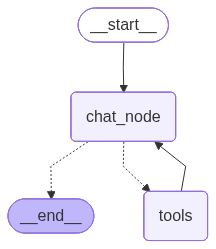

In [33]:
chatbot

In [34]:
result = chatbot.invoke({
    "messages":[
        HumanMessage(
            content=(
                "Explain linear regression and provide examples of its applications."
            )
        )
    ]
})

In [35]:
print(result['messages'][-1].content)

Linear regression is a simple approach for supervised learning, particularly useful for predicting a quantitative response. It has been around for a long time and is the topic of innumerable textbooks. While it may seem somewhat dull compared to some of the more modern statistical learning approaches, linear regression is still a useful and widely used statistical learning method. Moreover, it serves as a good jumping-off point for newer approaches: as we will see in later chapters, many fancy statistical learning approaches can be seen as generalizations or extensions of linear regression.

Examples of applications:
*   Predicting a quantitative response.
*   Estimating unknown coefficients.
